<br>

## Loading libraries

In [3]:
# core
import gym
import wandb
import numpy as np

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

wandb.login();

wandb: Currently logged in as: vinas (use `wandb login --relogin` to force relogin)


<br>
<br>
<br>

## Setting up wandb environment

In [4]:
run = wandb.Api().run(f'/MountainCarProblem/12rh1pdt')
PARAMS = run.config
run.file('q_table.npy').download(replace=True)
q_table = np.load('./q_table.npy')

In [13]:
PARAMS.update({
    'max_steps': 3000,
    'J': 450
})

wandb.init(project='MountainCarProblem', config=PARAMS, reinit=True)
wandb.save('./2_offline_rbf.ipynb')
PARAMS = wandb.config

<br>
<br>
<br>

## Creating the modelling environment

In [7]:
env_name = 'MountainCar-v0'
env = gym.make(env_name).unwrapped
env_low = env.observation_space.low
env_high = env.observation_space.high

<br>
<br>
<br>

## Creating the Design and Target matrices for regression

In [8]:
# Discretise the states
def discretization(obs):
    env_den = (env_high - env_low) / PARAMS['n_states']
    return ((obs - env_low) / env_den).astype(int)

In [9]:
# Creating a design matrix from all possible state-action combinations
ls = np.linspace(env_low, env_high, PARAMS['n_states']).T
X = np.array(np.meshgrid(ls[0], ls[1], range(env.action_space.n))).T.reshape(-1,3).round(3)

actions = X[:,2].astype(int)
onehot_actions = np.eye(env.action_space.n)[actions]
X = np.concatenate((X[:,:2], onehot_actions), axis=1)
X

array([[-1.2  , -0.07 ,  1.   ,  0.   ,  0.   ],
       [-1.2  , -0.066,  1.   ,  0.   ,  0.   ],
       [-1.2  , -0.063,  1.   ,  0.   ,  0.   ],
       ...,
       [ 0.6  ,  0.063,  0.   ,  0.   ,  1.   ],
       [ 0.6  ,  0.066,  0.   ,  0.   ,  1.   ],
       [ 0.6  ,  0.07 ,  0.   ,  0.   ,  1.   ]])

In [10]:
# Creating a target array with values for every state-action combination
y = []
for i in range(len(X)):
    pos, vel = discretization(X[i,:2])
    vals = q_table[pos][vel][np.argmax(X[i, 2:])]
    y.append(vals)
    
y = np.array(y).reshape(-1,1)
y

array([[ 0.        ],
       [ 0.        ],
       [-5.85198506],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

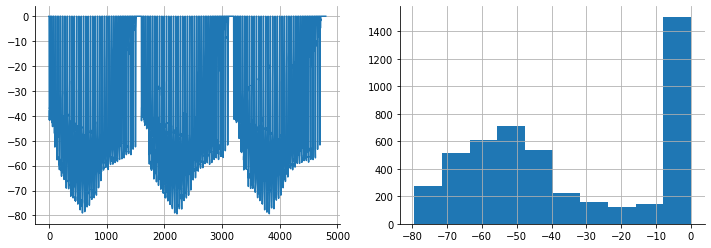

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].plot(y)
ax[0].grid()
ax[1].hist(y)
ax[1].grid()
sns.despine()

<br>
<br>
<br>

## Fitting RBF regression

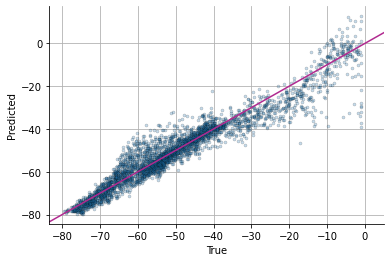

In [14]:
def runRBF(PARAMS, plot=True):
    
    # J basis functions obtained by k-means clustering
    # sigma set to standard deviation of entire data
    N = len(X)
    np.random.seed(PARAMS['seed'])
    kmeans = KMeans(n_clusters=PARAMS['J'], random_state=PARAMS['seed']).fit(X)
    sig = np.std(X)

    # Construct design matrix
    U = np.zeros((N,PARAMS['J']))
    for i in range(N):
        U[i] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_, axis=1)/sig)
        
    U = U[np.where(y!=0)[0],:]
    yt = y[np.where(y!=0)[0]]
        
    # Solve RBF model, predict and plot
    w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) @ yt

    # Predict the target
    yh_rbf = np.dot(U,w)
    
    if plot:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(yt, yh_rbf, '.', alpha=0.25, markeredgecolor='k', markeredgewidth=0.5)
        ax.grid()
        ax.axline([0, 0], [1, 1], color='#B12A90')
        ax.set(#title=f'Prediction under RBF({PARAMS["J"]}) transform',
               xlabel='True', ylabel='Predicted')
        sns.despine()
        
        plt.savefig('./Plots/rbf_regression.png', bbox_inches='tight', pad_inches=0.1)
    
    return (w, kmeans, sig, PARAMS['J']), yh_rbf

rbf_settings, y_hat = runRBF(PARAMS)
np.save('./weights', rbf_settings[0])
wandb.save('./weights.npy');

In [ ]:
if False:
    mses = []
    jays = [10, 20, 50, 75, 100, 120, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600, 700]
    for j in jays:
        pars = {'J': j, 'seed': PARAMS['seed']}
        rbf_settings, y_hat = runRBF(pars, plot=False)
        mses.append(mean_squared_error(y[np.where(y!=0)[0]], y_hat))

    plt.plot(jays[:-1], mses[:-1])
    plt.ylim([0, 300])
    plt.grid()
    plt.xlabel('J')
    plt.ylabel('MSE')
    plt.title('MSE per RBF functions used')
    sns.despine()

    plt.savefig('./Plots/mses.png', bbox_inches='tight', pad_inches=0.1)

<img src='./Plots/mses.png'>

<br>
<br>
<br>

## Testing what the agent learnt

In [10]:
def get_value(state_act, rbf_settings):
    # Predicting the value of a given state-action combination
    w, kmeans, sig, J = rbf_settings
    xx = np.array([state_act])
    uu = np.exp(-np.linalg.norm(xx - kmeans.cluster_centers_, axis=1)/sig).reshape(1,-1)
    return np.dot(uu, w)[0][0]

def pos2coord(pos):
    # converting discretised pos back to environment pos
    return (env_high[0] - env_low[0]) * pos/PARAMS['n_states'] + env_low[0]

def vel2coord(vel):
    # converting discretised vel back to environment vel
    return (env_high[1] - env_low[1]) * vel/PARAMS['n_states'] + env_low[1]

In [11]:
render = False
env.seed(PARAMS['seed'])
np.random.seed(PARAMS['seed'])
for episode in range(PARAMS['episodes']):

    # [1] Reseting the environment and adjusting the learning rate
    obs = env.reset()
    alpha = max(PARAMS['min_lr'], PARAMS['initial_lr']*(PARAMS['gamma']**(episode//100)))
    wandb.log({'lr': alpha}, step=episode)

    # [2] Initiating the agent
    steps = 0
    while True:

        # [3] Discretising the observed state
        if render:
            env.render()
        pos, vel = discretization(obs)

        # [4] Predicting state values
        values = np.array([get_value([pos2coord(pos), vel2coord(vel), 1, 0, 0], rbf_settings),
                           get_value([pos2coord(pos), vel2coord(vel), 0, 1, 0], rbf_settings),
                           get_value([pos2coord(pos), vel2coord(vel), 0, 0, 1], rbf_settings)])

        # [5] Choosing an action
        if np.random.uniform(low=0, high=1) < PARAMS['epsilon']:
            a = env.action_space.sample()
        else:
            a = np.argmax(values)

        # [6] Taking the action, receiving a reward
        obs, reward, done, _ = env.step(a)
        pos_, vel_ = discretization(obs)

        # [7] No Q function update
        steps += 1
        if done or steps>=PARAMS['max_steps']:
            if episode in np.linspace(0, PARAMS['episodes'], 11).astype(int):
                print(f'J: {PARAMS["J"]} | Episode: {episode} | Steps: {steps}')
            wandb.log({'steps': steps}, step=episode)
            break

J: 450 | Episode: 0 | Steps: 158
J: 450 | Episode: 500 | Steps: 162
J: 450 | Episode: 1000 | Steps: 183
J: 450 | Episode: 1500 | Steps: 167
J: 450 | Episode: 2000 | Steps: 189
J: 450 | Episode: 2500 | Steps: 163
J: 450 | Episode: 3000 | Steps: 171
J: 450 | Episode: 3500 | Steps: 158
J: 450 | Episode: 4000 | Steps: 165
J: 450 | Episode: 4500 | Steps: 166
